In [4]:

#LOAD ALL DATA
import sqlite3
import pandas as pd
import datetime
import os


dbFile ='.\\NSE_1min_DATA.sqlite.db'

def getSymbolsData(symbol):
    symbol = symbol.upper()
    if not os.path.exists(dbFile):
        print("File does not exist")
        return None
    conn = sqlite3.connect(dbFile)
    #conn = sqlite3.connect('.\\NSE_MASTER_DATA.sqlite.db')
    df = pd.read_sql_query("SELECT  * FROM  '"+symbol+"' ", conn)
    conn.close()
    return df


###
### START FROM HERE 
data = getSymbolsData("FACT-EQ")

 

import pandas as pd
import numpy as np
from nltk import ngrams
from collections import Counter 

# Load your OHLCV data

df2 = data[['Date','time','Open',   'High',    'Low',  'Close',  'Volume' ]].copy()


df = df2.rename(columns={ 'time':'Time'})
# If your columns are named exactly "Date" and "Time"
df['Date_Time'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))


In [5]:

#df = data.copy()#pd.read_csv('your_data.csv', parse_dates=[['Date', 'Time']])

# --- Step 1: Compute body size ---
df['body_size'] = (df['Close'] - df['Open']).abs()

# --- Step 2: Categorize body size ---
df['size_category'] = pd.qcut(df['body_size'], q=6, labels=False, duplicates='drop')

# --- Step 3: Categorize volume ---
mean_vol = df['Volume'].mean()
std_vol = df['Volume'].std()
def volume_category(v):
    if v < mean_vol - std_vol:
        return 1  # Low
    elif v > mean_vol + std_vol:
        return 3  # High
    else:
        return 2  # Average

 

df['volume_category'] = df['Volume'].apply(volume_category)

# --- Step 4: Build the sequence ---
sequence = list(zip(df['Date_Time'], df['size_category'], df['volume_category']))

# --- Step 5: Extract repeated n-grams (patterns) ---
n = 5  # sequence length
cat_sequence = [(s, v) for _, s, v in sequence]
ngrams_list = list(ngrams(cat_sequence, n))
pattern_counts = Counter(ngrams_list)

# --- Step 6: Display top patterns ---
print("Top repeating patterns:")
for pattern, count in pattern_counts.most_common(10):
    print(f"{pattern} → Count: {count}")

# Optional: View patterns with actual timestamps
print("\nPattern occurrences (with time):")
pattern_to_search = pattern_counts.most_common(1)[0][0]  # most common pattern

# Find all timestamps where the pattern occurs
timestamps = []
for i in range(len(cat_sequence) - n + 1):
    if tuple(cat_sequence[i:i+n]) == pattern_to_search:
        time_slice = df.iloc[i:i+n]['Date_Time'].tolist()
        timestamps.append(time_slice)

for t in timestamps:
    print(t)


Top repeating patterns:
((5, 2), (5, 2), (5, 2), (5, 2), (5, 2)) → Count: 46
((0, 2), (0, 2), (0, 2), (1, 2), (0, 2)) → Count: 13
((5, 2), (5, 2), (5, 2), (5, 2), (4, 2)) → Count: 10
((0, 2), (0, 2), (0, 2), (0, 2), (1, 2)) → Count: 10
((5, 2), (5, 2), (5, 2), (4, 2), (5, 2)) → Count: 9
((0, 2), (0, 2), (0, 2), (0, 2), (0, 2)) → Count: 9
((0, 2), (0, 2), (2, 2), (0, 2), (0, 2)) → Count: 9
((5, 2), (3, 2), (5, 2), (5, 2), (5, 2)) → Count: 8
((3, 2), (5, 2), (5, 2), (5, 2), (5, 2)) → Count: 8
((1, 2), (0, 2), (0, 2), (0, 2), (0, 2)) → Count: 8

Pattern occurrences (with time):
[Timestamp('2025-03-19 09:17:54'), Timestamp('2025-03-19 09:18:49'), Timestamp('2025-03-19 09:19:52'), Timestamp('2025-03-19 09:20:54'), Timestamp('2025-03-19 09:21:56')]
[Timestamp('2025-03-19 09:18:49'), Timestamp('2025-03-19 09:19:52'), Timestamp('2025-03-19 09:20:54'), Timestamp('2025-03-19 09:21:56'), Timestamp('2025-03-19 09:22:57')]
[Timestamp('2025-03-19 09:19:52'), Timestamp('2025-03-19 09:20:54'), Timesta

In [8]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio
#pio.renderers.default = 'iframe'
# pio.renderers.default = "notebook_connected"
pio.renderers.default = "vscode"

# --- Limit data to last 300 rows for clarity and performance ---
plot_df = df.copy()
plot_df = plot_df[-300:].reset_index(drop=True)

# --- Color candles based on size_category ---
def color_by_size_cat(size_cat):
    if size_cat == 0:
        return 'lightgray'
    elif size_cat > 0:
        return f'rgba(0, 200, 200, {0.4 + 0.1 * size_cat})'  # Shades of green
    elif size_cat < 0:
        return f'rgba(200, 0, 290, {0.4 + 0.1 * abs(size_cat)})'  # Shades of red
    else:
        return 'gray'

plot_df['Color'] = plot_df['size_category'].apply(color_by_size_cat)

# --- Create candlestick chart with Plotly ---
fig = go.Figure(data=[go.Candlestick(
    x=plot_df['Date_Time'],
    open=plot_df['Open'],
    high=plot_df['High'],
    low=plot_df['Low'],
    close=plot_df['Close'],
    increasing_line_color='green',
    decreasing_line_color='red',
    increasing_fillcolor=None,  # We'll override with custom color
    decreasing_fillcolor=None,
    showlegend=False
)])

# --- Override candle fill color with size_category colors ---
for i, row in plot_df.iterrows():
    color = row['Color']
    fig.add_shape(
        type='rect',
        x0=row['Date_Time'],
        x1=row['Date_Time'],
        y0=row['Low'],
        y1=row['High'],
        line=dict(width=0),
        fillcolor='blue',
        opacity=0.8,
        xref='x',
        yref='y'
    )

# --- Add Volume as a separate trace ---
fig.add_trace(go.Bar(
    x=plot_df['Date_Time'],
    y=plot_df['Volume'],
    name='Volume',
    marker_color='lightgray',
    yaxis='y2',
    opacity=0.3
))

# --- Layout: make it zoomable and nice ---
fig.update_layout(
    title='Candlestick Chart with Custom Coloring by Size Category',
    xaxis_rangeslider_visible=False,
    xaxis=dict(type='category'),
    yaxis=dict(domain=[0.3, 1]),
    yaxis2=dict(domain=[0, 0.25], title='Volume'),
    height=700,
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


In [9]:
import plotly.graph_objects as go
import pandas as pd

# --- Trim to last 300 rows for better visualization ---
plot_df = df[-300:].copy().reset_index(drop=True)

# --- Define candle colors based on size_category ---
def color_by_size_cat(cat):
    if pd.isna(cat): return 'gray'
    if cat == 0: return 'lightgray'
    if cat == 1: return '#a8e6a1'  # light green
    if cat == 2: return '#5dd75d'  # medium green
    if cat >= 3: return '#2b8c2b'  # dark green
    if cat == -1: return '#f7a8a8'  # light red
    if cat == -2: return '#f75d5d'  # medium red
    if cat <= -3: return '#c62828'  # dark red
    return 'gray'

# --- Define volume bar colors based on volume_category ---
def volume_color(cat):
    if cat == 1: return 'blue'
    if cat == 2: return 'gray'
    if cat == 3: return 'orange'
    return 'lightgray'

plot_df['CandleColor'] = plot_df['size_category'].apply(color_by_size_cat)
plot_df['VolumeColor'] = plot_df['volume_category'].apply(volume_color)

# --- Create the custom candlesticks manually ---
candle_shapes = []
for i, row in plot_df.iterrows():
    # Wick (line from low to high)
    candle_shapes.append(go.Scatter(
        x=[row['Date_Time'], row['Date_Time']],
        y=[row['Low'], row['High']],
        mode='lines',
        line=dict(color='black', width=1),
        showlegend=False,
        hoverinfo='skip'
    ))
    # Candle body
    candle_shapes.append(go.Scatter(
        x=[row['Date_Time'], row['Date_Time']],
        y=[row['Open'], row['Close']],
        mode='lines',
        line=dict(color=row['CandleColor'], width=6),
        showlegend=False,
        hoverinfo='skip'
    ))

# --- Add volume bars ---
volume_bars = go.Bar(
    x=plot_df['Date_Time'],
    y=plot_df['Volume'],
    marker_color=plot_df['VolumeColor'],
    yaxis='y2',
    name='Volume',
    opacity=0.6
)

# --- Build figure ---
fig = go.Figure(data=candle_shapes + [volume_bars])

# --- Layout ---
fig.update_layout(
    title='Candlestick Chart with Body Size & Volume Category Colors',
    xaxis=dict(
        rangeslider=dict(visible=False),
        type='category',
        showgrid=False
    ),
    yaxis=dict(domain=[0.3, 1], title='Price'),
    yaxis2=dict(domain=[0, 0.25], title='Volume'),
    height=700,
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


In [10]:



df2 = data[['Date','time','Open',   'High',    'Low',  'Close',  'Volume' ]].copy()


df = df2.rename(columns={ 'time':'Time'})
# If your columns are named exactly "Date" and "Time"
#df['Date_Time'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
import pandas as pd
import numpy as np
from nltk import ngrams
from collections import Counter

# Load your OHLCV data
#df = pd.read_csv('your_data.csv')

# Combine Date and Time columns into a single datetime
df['Date_Time'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Compute candle body size (with sign based on color)
df['body_size'] = df['Close'] - df['Open']

# Calculate ATR using 14-period average
df['high_low'] = df['High'] - df['Low']
df['high_close_prev'] = (df['High'] - df['Close'].shift()).abs()
df['low_close_prev'] = (df['Low'] - df['Close'].shift()).abs()

df['TR'] = df[['high_low', 'high_close_prev', 'low_close_prev']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()

# --- Categorize Body Size Based on ATR and Candle Color ---
def categorize_body_size(row):
    atr = row['ATR']
    if pd.isna(atr) or atr == 0:
        return np.nan  # skip until ATR is available

    size = row['body_size']
    ratio = abs(size) / atr

    if ratio < 0.5:
        return 0
    else:
        level = int(ratio + 0.5)  # Round to nearest whole multiple
        return level if size > 0 else -level

df['size_category'] = df.apply(categorize_body_size, axis=1)

# --- Volume categories based on std. deviation ---
mean_vol = df['Volume'].mean()
std_vol = df['Volume'].std()

def volume_category(v):
    if v < mean_vol - std_vol:
        return 1  # Low
    elif v > mean_vol + std_vol:
        return 3  # High
    else:
        return 2  # Average

df['volume_category'] = df['Volume'].apply(volume_category)

# --- Build the pattern sequence ---
sequence = list(zip(df['Date_Time'], df['size_category'], df['volume_category']))

# Drop rows where size_category is NaN (ATR not available yet)
sequence = [(dt, s, v) for dt, s, v in sequence if pd.notna(s)]

# --- Pattern mining ---
n = 5  # length of pattern
cat_sequence = [(s, v) for _, s, v in sequence]
ngrams_list = list(ngrams(cat_sequence, n))
pattern_counts = Counter(ngrams_list)

# --- Output: Top Patterns ---
print("Top repeating patterns:")
for pattern, count in pattern_counts.most_common(10):
    print(f"{pattern} → Count: {count}")

# --- Pattern timestamps (optional) ---
top_pattern = pattern_counts.most_common(1)[0][0]
timestamps = []
for i in range(len(cat_sequence) - n + 1):
    if tuple(cat_sequence[i:i+n]) == top_pattern:
        times = [sequence[i + j][0] for j in range(n)]
        timestamps.append(times)

print("\nTimestamps for top pattern:")
for t in timestamps:
    print(t)


Top repeating patterns:
((0.0, 2), (0.0, 2), (0.0, 2), (0.0, 2), (0.0, 2)) → Count: 412
((-1.0, 2), (0.0, 2), (0.0, 2), (0.0, 2), (0.0, 2)) → Count: 140
((0.0, 2), (0.0, 2), (1.0, 2), (0.0, 2), (0.0, 2)) → Count: 132
((0.0, 2), (0.0, 2), (0.0, 2), (0.0, 2), (-1.0, 2)) → Count: 127
((0.0, 2), (0.0, 2), (-1.0, 2), (0.0, 2), (0.0, 2)) → Count: 127
((0.0, 2), (-1.0, 2), (0.0, 2), (0.0, 2), (0.0, 2)) → Count: 126
((0.0, 2), (0.0, 2), (0.0, 2), (-1.0, 2), (0.0, 2)) → Count: 121
((0.0, 2), (0.0, 2), (0.0, 2), (0.0, 2), (1.0, 2)) → Count: 112
((0.0, 2), (1.0, 2), (0.0, 2), (0.0, 2), (0.0, 2)) → Count: 112
((1.0, 2), (0.0, 2), (0.0, 2), (0.0, 2), (0.0, 2)) → Count: 103

Timestamps for top pattern:
[Timestamp('2025-03-19 09:59:58'), Timestamp('2025-03-19 10:00:49'), Timestamp('2025-03-19 10:01:53'), Timestamp('2025-03-19 10:02:58'), Timestamp('2025-03-19 10:03:55')]
[Timestamp('2025-03-19 10:00:49'), Timestamp('2025-03-19 10:01:53'), Timestamp('2025-03-19 10:02:58'), Timestamp('2025-03-19 10:03:

In [11]:
import plotly.graph_objects as go
import pandas as pd
from collections import Counter
from nltk import ngrams

# --- Limit data to last 300 rows for clarity ---
plot_df = df[-300:].copy().reset_index(drop=True)

# --- Build the sequence ---
sequence = list(zip(plot_df['Date_Time'], plot_df['size_category'], plot_df['volume_category']))
n = 5  # Length of pattern to look for (you can adjust this)
cat_sequence = [(s, v) for _, s, v in sequence]
ngrams_list = list(ngrams(cat_sequence, n))
pattern_counts = Counter(ngrams_list)

# --- Get the top patterns (e.g., top 3 most common patterns) ---
top_patterns = pattern_counts.most_common(8)  # Top 3 most common patterns
# top_patterns = pattern_counts.most_common(8)  # Top 3 most common patterns

print("Top Patterns:", top_patterns)  # To view the most common patterns

# --- Define a color palette for the patterns ---
pattern_colors = {
    0: 'yellow',  # First pattern color
    1: 'cyan',    # Second pattern color
    2: 'magenta' , # Third pattern color
    3: 'red',  # Third pattern color
    4: 'green' , # Third pattern color
    5: 'blue' , # Third pattern color
    6: 'maroon',  # Third pattern color
    7: 'darkturquoise'  # Third pattern color
}

# --- Function to color candles based on pattern match ---
def color_by_pattern(i):
    for idx, (pattern, _) in enumerate(top_patterns):
        if i < n - 1:
            continue  # Skip first n-1 candles as they can't form a complete pattern
        for j in range(len(cat_sequence) - n + 1):
            if tuple(cat_sequence[j:j+n]) == pattern:  # Check if current sequence matches
                # Highlight these candles with the specific color for the matched pattern
                if i >= j and i < j + n:
                    return pattern_colors[idx]  # Color from the pattern_colors mapping
    return 'lightgray'  # Default color for non-matching candles

# --- Assign color to each candle based on matching the pattern ---
plot_df['CandleColor'] = [color_by_pattern(i) for i in range(len(plot_df))]

# --- Create custom candlesticks manually ---
candle_shapes = []
for i, row in plot_df.iterrows():
    # Wick (line from low to high)
    candle_shapes.append(go.Scatter(
        x=[row['Date_Time'], row['Date_Time']],
        y=[row['Low'], row['High']],
        mode='lines',
        line=dict(color='black', width=1),
        showlegend=False,
        hoverinfo='skip'
    ))
    # Candle body
    candle_shapes.append(go.Scatter(
        x=[row['Date_Time'], row['Date_Time']],
        y=[row['Open'], row['Close']],
        mode='lines',
        line=dict(color=row['CandleColor'], width=6),
        showlegend=False,
        hoverinfo='skip'
    ))

# --- Add volume bars ---
volume_bars = go.Bar(
    x=plot_df['Date_Time'],
    y=plot_df['Volume'],
    marker_color='lightgray',  # Default color for volume
    yaxis='y2',
    name='Volume',
    opacity=0.3
)

# --- Build figure ---
fig = go.Figure(data=candle_shapes + [volume_bars])

# --- Layout ---
fig.update_layout(
    title='Candlestick Chart with Highlighted Multiple Pattern Matches',
    xaxis=dict(
        rangeslider=dict(visible=False),
        type='category',
        showgrid=False
    ),
    yaxis=dict(domain=[0.3, 1], title='Price'),
    yaxis2=dict(domain=[0, 0.25], title='Volume'),
    height=700,
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


Top Patterns: [(((0.0, 3), (0.0, 3), (0.0, 3), (0.0, 3), (0.0, 3)), 5), (((0.0, 3), (0.0, 3), (1.0, 3), (0.0, 3), (0.0, 3)), 4), (((0.0, 3), (1.0, 3), (0.0, 3), (0.0, 3), (0.0, 3)), 4), (((0.0, 3), (0.0, 3), (0.0, 3), (1.0, 3), (0.0, 3)), 3), (((-1.0, 3), (1.0, 3), (0.0, 3), (0.0, 3), (0.0, 3)), 3), (((1.0, 3), (0.0, 3), (0.0, 3), (0.0, 3), (0.0, 3)), 3), (((0.0, 3), (0.0, 3), (0.0, 3), (0.0, 3), (-1.0, 3)), 3), (((0.0, 3), (-1.0, 3), (0.0, 3), (-1.0, 3), (0.0, 3)), 2)]


In [17]:

#LOAD ALL DATA
import sqlite3
import pandas as pd
import datetime
import os


dbFile ='.\\NSE_1min_DATA.sqlite.db'

def getSymbolsData(symbol):
    symbol = symbol.upper()
    if not os.path.exists(dbFile):
        print("File does not exist")
        return None
    conn = sqlite3.connect(dbFile)
    #conn = sqlite3.connect('.\\NSE_MASTER_DATA.sqlite.db')
    data = pd.read_sql_query("SELECT  * FROM  '"+symbol+"' ", conn)
    conn.close()
    df2 = data[['Date','time','Open',   'High',    'Low',  'Close',  'Volume' ]].copy()
    df = df2.rename(columns={ 'time':'Time'})
    # Combine Date and Time columns into a single datetime
    df['Date_Time'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))
    
    return df


###
### START FROM HERE 
data = getSymbolsData("FACT-EQ")




In [12]:
import plotly.graph_objects as go
import pandas as pd
from collections import defaultdict, Counter
from nltk import ngrams
import numpy as np


# # Simulate a sample DataFrame (replace with your real OHLCV data)
# np.random.seed(42)
# dates = pd.date_range(start="2023-01-01", periods=300, freq="H")
# df = pd.DataFrame({
#     "Date_Time": dates,
#     "Open": np.random.uniform(100, 110, size=300),
#     "High": np.random.uniform(110, 115, size=300),
#     "Low": np.random.uniform(95, 100, size=300),
#     "Close": np.random.uniform(100, 110, size=300),
#     "Volume": np.random.randint(1000, 10000, size=300)
# })

# Compute body size and ATR
df['body_size'] = abs(df['Close'] - df['Open'])
atr = df['body_size'].rolling(window=14).mean()
df['size_category'] = ((df['Close'] - df['Open']) / atr).fillna(0)
df['size_category'] = df['size_category'].apply(lambda x: 0 if abs(x) < 0.5 else int(np.sign(x) * min(abs(x), 3)))

# Volume categories
vol_mean = df['Volume'].mean()
vol_std = df['Volume'].std()
df['volume_category'] = ((df['Volume'] - vol_mean) / vol_std).apply(lambda x: 1 if x < -0.5 else (3 if x > 0.5 else 2))

# Limit to last 100 for clarity
plot_df = df[-300:].copy().reset_index(drop=True)

# --- Pattern Prediction ---
sequence = list(zip(plot_df['size_category'], plot_df['volume_category']))
n = 3
ngrams_seq = list(ngrams(sequence, n + 1))
pattern_map = defaultdict(Counter)
for gram in ngrams_seq:
    pattern = gram[:-1]
    next_step = gram[-1]
    pattern_map[pattern][next_step] += 1

latest_pattern = tuple(sequence[-n:])
prediction_counter = pattern_map.get(latest_pattern, {})
most_likely = prediction_counter.most_common(3)

if most_likely:
    pred_cat = most_likely[0][0]
    pred_prob = most_likely[0][1] / sum(prediction_counter.values())
    last_close = plot_df.iloc[-1]['Close']
    atr_latest = atr.iloc[-1] if not np.isnan(atr.iloc[-1]) else 1
    size = pred_cat[0] * atr_latest
    pred_open = last_close
    pred_close = last_close + size
    pred_high = max(pred_open, pred_close) + atr_latest * 0.2
    pred_low = min(pred_open, pred_close) - atr_latest * 0.2
    pred_row = {
        "Date_Time": plot_df.iloc[-1]['Date_Time'] + pd.Timedelta(hours=1),
        "Open": pred_open,
        "Close": pred_close,
        "High": pred_high,
        "Low": pred_low,
        "Volume": vol_mean + pred_cat[1] * vol_std * 0.5,
        "color": "rgba(0,0,255,0.4)",
        "probability": f"{pred_prob:.1%}"
    }
else:
    pred_row = None

# --- Plotting ---
fig = go.Figure()

for i, row in plot_df.iterrows():
    fig.add_trace(go.Scatter(
        x=[row['Date_Time'], row['Date_Time']],
        y=[row['Low'], row['High']],
        mode='lines',
        line=dict(color='black', width=1),
        showlegend=False,
        hoverinfo='skip'
    ))
    fig.add_trace(go.Scatter(
        x=[row['Date_Time'], row['Date_Time']],
        y=[row['Open'], row['Close']],
        mode='lines',
        line=dict(color='green' if row['Close'] > row['Open'] else 'red', width=6),
        showlegend=False,
        hoverinfo='skip'
    ))

# Predicted ghost candle
if pred_row:
    fig.add_trace(go.Scatter(
        x=[pred_row['Date_Time'], pred_row['Date_Time']],
        y=[pred_row['Low'], pred_row['High']],
        mode='lines',
        line=dict(color='blue', width=1, dash='dot'),
        name='Predicted Wick'
    ))
    fig.add_trace(go.Scatter(
        x=[pred_row['Date_Time'], pred_row['Date_Time']],
        y=[pred_row['Open'], pred_row['Close']],
        mode='lines',
        line=dict(color=pred_row['color'], width=6),
        name=f"Predicted Candle ({pred_row['probability']} confidence)",
        hovertext=f"Predicted size_cat: {pred_cat[0]}, vol_cat: {pred_cat[1]}<br>Confidence: {pred_row['probability']}"
    ))

fig.update_layout(
    title='Candlestick Chart with Predicted Ghost Candle',
    xaxis=dict(rangeslider=dict(visible=False)),
    yaxis=dict(title='Price'),
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()


Function: analyze_pattern_accuracy(df)

In [15]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from nltk import ngrams

def analyze_pattern_accuracy(df, seq_len=3):
    df = df.copy()

    # Categorize candles
    df['body_size'] = abs(df['Close'] - df['Open'])
    atr = df['body_size'].rolling(window=14).mean()
    df['size_category'] = ((df['Close'] - df['Open']) / atr).fillna(0)
    df['size_category'] = df['size_category'].apply(lambda x: 0 if abs(x) < 0.5 else int(np.sign(x) * min(abs(x), 3)))

    vol_mean = df['Volume'].mean()
    vol_std = df['Volume'].std()
    df['volume_category'] = ((df['Volume'] - vol_mean) / vol_std).apply(
        lambda x: 1 if x < -0.5 else (3 if x > 0.5 else 2))

    # Build sequence
    sequence = list(zip(df['size_category'], df['volume_category']))
    next_moves = df['Close'].diff().apply(np.sign).shift(-1).fillna(0)  # actual direction of next candle

    pattern_stats = defaultdict(lambda: {"correct": 0, "total": 0})

    for i in range(len(sequence) - seq_len - 1):
        pattern = tuple(sequence[i:i+seq_len])
        actual_move = next_moves.iloc[i+seq_len]
        predicted_move = np.sign(sequence[i+seq_len][0])  # we predict direction from size_category sign

        pattern_stats[pattern]["total"] += 1
        if predicted_move == actual_move:
            pattern_stats[pattern]["correct"] += 1

    # Build a sorted list of patterns
    result = []
    for pattern, stats in pattern_stats.items():
        if stats["total"] >= 5:  # Only include patterns with enough data
            acc = stats["correct"] / stats["total"]
            result.append({
                "pattern": pattern,
                "accuracy": round(acc * 100, 2),
                "correct": stats["correct"],
                "total": stats["total"]
            })

    result = sorted(result, key=lambda x: x["accuracy"], reverse=True)
    return pd.DataFrame(result)


In [18]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from nltk import ngrams

# # --- Simulated OHLCV data (Replace with real) ---
# np.random.seed(42)
# dates = pd.date_range("2023-01-01", periods=300, freq="H")
# df = pd.DataFrame({
#     "Date_Time": dates,
#     "Open": np.random.uniform(100, 110, 300),
#     "High": np.random.uniform(110, 115, 300),
#     "Low": np.random.uniform(95, 100, 300),
#     "Close": np.random.uniform(100, 110, 300),
#     "Volume": np.random.randint(1000, 10000, 300)
# })
df = getSymbolsData("FACT-EQ")
# --- Candle Categories ---
df['body_size'] = abs(df['Close'] - df['Open'])
atr = df['body_size'].rolling(window=14).mean()
df['size_category'] = ((df['Close'] - df['Open']) / atr).fillna(0)
df['size_category'] = df['size_category'].apply(lambda x: 0 if abs(x) < 0.5 else int(np.sign(x) * min(abs(x), 3)))
vol_mean = df['Volume'].mean()
vol_std = df['Volume'].std()
df['volume_category'] = ((df['Volume'] - vol_mean) / vol_std).apply(lambda x: 1 if x < -0.5 else (3 if x > 0.5 else 2))

# --- Recent data only ---
plot_df = df[-100:].copy().reset_index(drop=True)

# --- Pattern Model ---
sequence = list(zip(plot_df['size_category'], plot_df['volume_category']))
n = 7
ngrams_seq = list(ngrams(sequence, n + 1))
pattern_map = defaultdict(Counter)
for gram in ngrams_seq:
    pattern_map[gram[:-1]][gram[-1]] += 1

# --- Predict multiple future candles ---
num_predictions = 5
predicted_candles = []
recent_seq = sequence[-n:]
last_close = plot_df.iloc[-1]['Close']
atr_latest = atr.iloc[-1] if not np.isnan(atr.iloc[-1]) else 1
next_time = plot_df.iloc[-1]['Date_Time']

for i in range(num_predictions):
    pred_counts = pattern_map.get(tuple(recent_seq), {})
    if not pred_counts:
        break  # Stop if we can't predict further

    next_cat = pred_counts.most_common(1)[0][0]
    confidence = pred_counts[next_cat] / sum(pred_counts.values())

    size = next_cat[0] * atr_latest
    pred_open = last_close
    pred_close = last_close + size
    pred_high = max(pred_open, pred_close) + atr_latest * 0.2
    pred_low = min(pred_open, pred_close) - atr_latest * 0.2
    next_time += pd.Timedelta(hours=1)

    predicted_candles.append({
        "Date_Time": next_time,
        "Open": pred_open,
        "Close": pred_close,
        "High": pred_high,
        "Low": pred_low,
        "Volume": vol_mean + next_cat[1] * vol_std * 0.5,
        "probability": f"{confidence:.1%}",
        "cat": next_cat
    })

    last_close = pred_close
    recent_seq = recent_seq[1:] + [next_cat]

# --- Plot Chart ---
fig = go.Figure()

# --- Plot Historical Candles ---
for i, row in plot_df.iterrows():
    fig.add_trace(go.Scatter(
        x=[str(row['Date_Time'])]*2,
        y=[row['Low'], row['High']],
        mode='lines',
        line=dict(color='black', width=1),
        showlegend=False
    ))
    fig.add_trace(go.Scatter(
        x=[str(row['Date_Time'])]*2,
        y=[row['Open'], row['Close']],
        mode='lines',
        line=dict(color='green' if row['Close'] > row['Open'] else 'red', width=6),
        showlegend=False
    ))

# --- Plot Predicted Ghost Candles ---
for i, row in enumerate(predicted_candles):
    base_color = f"rgba(0,0,255,{0.2 + i * 0.15})"
    fig.add_trace(go.Scatter(
        x=[str(row['Date_Time'])]*2,
        y=[row['Low'], row['High']],
        mode='lines',
        line=dict(color='blue', width=1, dash='dot'),
        showlegend=(i == 0),
        name='Predicted Wick' if i == 0 else None
    ))
    fig.add_trace(go.Scatter(
        x=[str(row['Date_Time'])]*2,
        y=[row['Open'], row['Close']],
        mode='lines',
        line=dict(color=base_color, width=6),
        name=f"Predicted Candle {i+1}",
        hovertext=f"Predicted: size_cat={row['cat'][0]}, vol_cat={row['cat'][1]}<br>Confidence: {row['probability']}"
    ))

# --- Layout Config ---
fig.update_layout(
    title='Candlestick Chart with Multi-Step Prediction',
    xaxis=dict(title='Time (No Gaps)', type='category', tickangle=-45),
    yaxis=dict(title='Price'),
    height=700,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()


In [ ]:
analyze_pattern_accuracy(df, seq_len=7)

In [ ]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from nltk import ngrams

def analyze_pattern_accuracy_full(df, seq_len=3, min_occurrences=5):
    df = df.copy()

    # Categorize candles
    df['body_size'] = abs(df['Close'] - df['Open'])
    atr = df['body_size'].rolling(window=14).mean()
    df['size_category'] = ((df['Close'] - df['Open']) / atr).fillna(0)
    df['size_category'] = df['size_category'].apply(lambda x: 0 if abs(x) < 0.5 else int(np.sign(x) * min(abs(x), 3)))

    vol_mean = df['Volume'].mean()
    vol_std = df['Volume'].std()
    df['volume_category'] = ((df['Volume'] - vol_mean) / vol_std).apply(
        lambda x: 1 if x < -0.5 else (3 if x > 0.5 else 2))

    sequence = list(zip(df['size_category'], df['volume_category']))
    ngram_data = list(ngrams(sequence, seq_len + 1))  # includes the target

    pattern_stats = defaultdict(lambda: {"counts": Counter(), "total": 0})

    for ngram_seq in ngram_data:
        pattern = ngram_seq[:-1]           # the pattern window
        actual_next = ngram_seq[-1]        # the actual next (size_cat, vol_cat)
        pattern_stats[pattern]["counts"][actual_next] += 1
        pattern_stats[pattern]["total"] += 1

    results = []
    for pattern, data in pattern_stats.items():
        total = data["total"]
        if total < min_occurrences:
            continue

        most_common, count = data["counts"].most_common(1)[0]
        direction_accuracy = count / total
        predicted_direction = np.sign(most_common[0])  # sign of size_category
        results.append({
            "pattern": pattern,
            "predicted": most_common,
            "accuracy": round(direction_accuracy * 100, 2),
            "predicted_direction": predicted_direction,
            "predicted_volume_cat": most_common[1],
            "correct": count,
            "total": total
        })

    return pd.DataFrame(results).sort_values(by="accuracy", ascending=False)





In [8]:

df = getSymbolsData("FACT-EQ")
# --- Candle Categories ---
df['body_size'] = abs(df['Close'] - df['Open'])
atr = df['body_size'].rolling(window=14).mean()
df['size_category'] = ((df['Close'] - df['Open']) / atr).fillna(0)
df['size_category'] = df['size_category'].apply(lambda x: 0 if abs(x) < 0.5 else int(np.sign(x) * min(abs(x), 3)))
vol_mean = df['Volume'].mean()
vol_std = df['Volume'].std()
df['volume_category'] = ((df['Volume'] - vol_mean) / vol_std).apply(lambda x: 1 if x < -0.5 else (3 if x > 0.5 else 2))


In [9]:
analyze_pattern_accuracy_full(df, seq_len=5)

,pattern,predicted,accuracy,predicted_direction,predicted_volume_cat,correct,total
212,"((0, 2), (2, 2), (-1, 2), (0, 2), (-1, 2))","(0, 2)",100.00,0,2,5,5
153,"((1, 2), (0, 2), (-1, 2), (0, 2), (-1, 2))","(0, 2)",100.00,0,2,5,5
44,"((-1, 2), (3, 2), (0, 2), (0, 2), (0, 2))","(0, 2)",100.00,0,2,5,5
176,"((1, 2), (2, 2), (0, 2), (0, 2), (0, 2))","(0, 2)",100.00,0,2,7,7
226,"((0, 2), (-1, 2), (1, 2), (-1, 2), (0, 2))","(0, 2)",100.00,0,2,5,5
...,...,...,...,...,...,...,...
182,"((0, 2), (1, 2), (-1, 2), (-1, 2), (0, 2))","(-2, 2)",33.33,-1,2,2,6
55,"((0, 2), (0, 2), (-2, 2), (0, 2), (-1, 2))","(0, 2)",30.00,0,2,3,10
128,"((0, 2), (0, 2), (0, 2), (0, 2), (-3, 2))","(-1, 2)",26.32,-1,2,5,19
217,"((1, 2), (0, 2), (0, 2), (-1, 2), (-1, 2))","(-1, 2)",20.00,-1,2,1,5


In [18]:
analyze_pattern_accuracy(df, seq_len=7)

,pattern,accuracy,correct,total
0,"((0, 2), (1, 2), (0, 2), (0, 2), (0, 2), (0, 2...",66.67,4,6
1,"((0, 2), (-2, 2), (-1, 2), (0, 2), (0, 2), (0,...",60.00,3,5
2,"((0, 2), (0, 2), (-1, 2), (1, 2), (0, 2), (0, ...",60.00,3,5
3,"((0, 2), (0, 2), (0, 2), (2, 2), (0, 2), (0, 2...",50.00,5,10
4,"((0, 2), (0, 2), (0, 2), (1, 2), (0, 2), (0, 2...",50.00,3,6
...,...,...,...,...
149,"((1, 2), (2, 2), (0, 2), (0, 2), (0, 2), (0, 2...",0.00,0,5
150,"((-1, 2), (-1, 2), (0, 2), (0, 2), (0, 2), (0,...",0.00,0,11
151,"((1, 2), (1, 2), (-1, 2), (0, 2), (0, 2), (0, ...",0.00,0,5
152,"((0, 2), (1, 2), (0, 2), (0, 2), (0, 2), (-1, ...",0.00,0,5


In [17]:
analyze_pattern_accuracy(df, seq_len=3)

,pattern,accuracy,correct,total
0,"((1, 2), (-2, 2), (1, 2))",80.00,4,5
1,"((0, 2), (1, 2), (3, 2))",71.43,5,7
2,"((-2, 2), (-2, 2), (0, 2))",66.67,6,9
3,"((-3, 2), (-1, 2), (-1, 2))",60.00,3,5
4,"((0, 2), (3, 2), (1, 2))",50.00,5,10
...,...,...,...,...
150,"((-2, 3), (0, 3), (0, 3))",0.00,0,6
151,"((0, 3), (0, 3), (0, 2))",0.00,0,5
152,"((1, 3), (1, 3), (-1, 3))",0.00,0,5
153,"((1, 3), (-1, 3), (0, 3))",0.00,0,5


In [12]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import ngrams

def analyze_pattern_accuracy_full(
    df, seq_len=3, min_occurrences=5, top_n_visualize=10, plot=True
):
    df = df.copy()

    # Add signed body size (+ve for green, -ve for red)
    df['bodysize'] = df['Close'] - df['Open']

    # Average True Range proxy (just using body size)
    atr = df['bodysize'].abs().rolling(window=14).mean()

    # Candle size category: normalized to ATR and clipped
    df['size_category'] = (df['bodysize'] / atr).fillna(0)
    df['size_category'] = df['size_category'].apply(lambda x: 0 if abs(x) < 0.5 else int(np.sign(x) * min(abs(x), 3)))

    # Volume category: z-score based
    vol_mean = df['Volume'].mean()
    vol_std = df['Volume'].std()
    df['volume_category'] = ((df['Volume'] - vol_mean) / vol_std).apply(
        lambda x: 1 if x < -0.5 else (3 if x > 0.5 else 2))

    # Form sequence: (size_cat, vol_cat)
    sequence = list(zip(df['size_category'], df['volume_category']))
    timestamps = df.index.tolist()

   # ngram_data = list(ngrams(sequence, seq_len + 1))
    future_step = 2  # how many candles ahead you want to predict
    ngram_data = [
        tuple(sequence[i:i + seq_len + future_step])
        for i in range(len(sequence) - seq_len - future_step + 1)
    ]

    ngram_timestamps = list(ngrams(timestamps, seq_len + 1))

    pattern_stats = defaultdict(lambda: {"counts": Counter(), "total": 0, "timestamps": []})

    for ngram_seq, ts_seq in zip(ngram_data, ngram_timestamps):
        pattern = ngram_seq[:seq_len]
        actual_next = ngram_seq[seq_len + future_step - 1]  # pick Nth future candle
        # pattern = ngram_seq[:-1]
        # actual_next = ngram_seq[-1]
        last_timestamp = ts_seq[-1]

        pattern_stats[pattern]["counts"][actual_next] += 1
        pattern_stats[pattern]["total"] += 1
        pattern_stats[pattern]["timestamps"].append(last_timestamp)

    results = []
    for pattern, data in pattern_stats.items():
        total = data["total"]
        if total < min_occurrences:
            continue

        most_common, count = data["counts"].most_common[0:]
        direction_accuracy = count / total

        # Direction-only evaluation
        predicted_dir = np.sign(most_common[0])  # size_category direction
        direction_counts = sum(
            1 for actual in data["counts"]
            if np.sign(actual[0]) == predicted_dir
        )
        direction_only_accuracy = direction_counts / total

        results.append({
            "pattern": pattern,
            "predicted": most_common,
            "accuracy": round(direction_accuracy * 100, 2),
            "direction_only_accuracy": round(direction_only_accuracy * 100, 2),
            "predicted_direction": predicted_dir,
            "predicted_volume_cat": most_common[1],
            "correct": count,
            "total": total,
            "timestamps": data["timestamps"]
        })

    result_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)

    # Optional visualization
    if plot and not result_df.empty:
        top_patterns = result_df.head(top_n_visualize)
        plt.figure(figsize=(12, 6))
        bars = plt.bar(
            [str(p) for p in top_patterns["pattern"]],
            top_patterns["accuracy"],
            color='skyblue',
            edgecolor='black'
        )
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Top {top_n_visualize} Patterns by Accuracy")
        plt.ylabel("Accuracy (%)")
        plt.xlabel("Pattern")
        plt.tight_layout()
        plt.show()

    return result_df


In [13]:
# assuming df is your OHLCV DataFrame with datetime index
results = analyze_pattern_accuracy_full(df, seq_len=5, min_occurrences=5,top_n_visualize=30)
print(results)


TypeError: 'method' object is not subscriptable

In [19]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from nltk import ngrams
import mplfinance as mpf

def analyze_pattern_accuracy_full(
    df, seq_len=5, future_steps=3, min_occurrences=5, top_n_visualize=10, plot=True
):
    df = df.copy()

    # Signed body size (+ve for green, -ve for red)
    df['bodysize'] = df['Close'] - df['Open']

    # ATR-like normalization
    atr = df['bodysize'].abs().rolling(window=14).mean()
    df['size_category'] = (df['bodysize'] / atr).fillna(0)
    df['size_category'] = df['size_category'].apply(
        lambda x: 0 if abs(x) < 0.5 else int(np.sign(x) * min(abs(x), 3))
    )

    # Volume category (z-score)
    vol_mean = df['Volume'].mean()
    vol_std = df['Volume'].std()
    df['volume_category'] = ((df['Volume'] - vol_mean) / vol_std).apply(
        lambda x: 1 if x < -0.5 else (3 if x > 0.5 else 2))

    sequence = list(zip(df['size_category'], df['volume_category']))
    timestamps = df.index.tolist()

    # Generate ngrams to include future_steps ahead
    total_len = seq_len + future_steps
    ngram_data = [
        tuple(sequence[i:i + total_len])
        for i in range(len(sequence) - total_len + 1)
    ]
    ngram_timestamps = [
        tuple(timestamps[i:i + total_len])
        for i in range(len(sequence) - total_len + 1)
    ]

    pattern_stats = defaultdict(lambda: {"counts": Counter(), "total": 0, "timestamps": []})

    for ngram_seq, ts_seq in zip(ngram_data, ngram_timestamps):
        pattern = tuple(ngram_seq[:seq_len])
        actual_future = ngram_seq[-future_steps]  # future_steps ahead
        future_timestamp = ts_seq[-future_steps]

        pattern_stats[pattern]["counts"][actual_future] += 1
        pattern_stats[pattern]["total"] += 1
        pattern_stats[pattern]["timestamps"].append(future_timestamp)

    results = []
    for pattern, data in pattern_stats.items():
        total = data["total"]
        if total < min_occurrences:
            continue

        most_common, count = data["counts"].most_common(1)[0]
        direction_accuracy = count / total

        # Direction-only accuracy
        predicted_dir = np.sign(most_common[0])
        direction_counts = sum(
            v for actual, v in data["counts"].items()
            if np.sign(actual[0]) == predicted_dir
        )
        direction_only_accuracy = direction_counts / total

        results.append({
            "pattern": pattern,
            "predicted": most_common,
            "accuracy": round(direction_accuracy * 100, 2),
            "direction_only_accuracy": round(direction_only_accuracy * 100, 2),
            "predicted_direction": predicted_dir,
            "predicted_volume_cat": most_common[1],
            "correct": count,
            "total": total,
            "timestamps": data["timestamps"]
        })

    result_df = pd.DataFrame(results).sort_values(by="accuracy", ascending=False)

    # Bar plot of top N patterns
    if plot and not result_df.empty:
        top_patterns = result_df.head(top_n_visualize)
        plt.figure(figsize=(12, 6))
        bars = plt.bar(
            [str(p) for p in top_patterns["pattern"]],
            top_patterns["accuracy"],
            color='skyblue',
            edgecolor='black'
        )
        plt.xticks(rotation=45, ha='right')
        plt.title(f"Top {top_n_visualize} Patterns by Accuracy ({future_steps} steps ahead)")
        plt.ylabel("Accuracy (%)")
        plt.xlabel("Pattern")
        plt.tight_layout()
        plt.show()

    return result_df


In [20]:
def plot_pattern_matches(df, pattern, pattern_timestamps, seq_len, future_steps):
    df = df.copy()
    df = df.loc[df.index.isin(pattern_timestamps)]  # Filter to matching points

    for ts in pattern_timestamps:
        print('in ')
        print(ts)
        try:
            # Get the full sequence starting before the prediction
            idx = df.index.get_loc(ts)
            start_idx = idx - future_steps - seq_len + 1
            end_idx = idx + 1
            print(idx)
            if start_idx < 0:
                continue

            sub_df = df.iloc[start_idx:end_idx]
            print(sub_df.head())
            # Add ghost candle (prediction)
            ghost_candle = sub_df.iloc[-1]
            pred_color = 'green' if ghost_candle['Close'] >= ghost_candle['Open'] else 'red'

            # Plot real candles
            mpf.plot(
                sub_df,
                type='candle',
                style='yahoo',
                title=f"Pattern Match ending at {ts}",
                ylabel="Price",
                ylabel_lower="Volume",
                volume=True,            
                
                warn_too_much_data=1000
            )
            
            # --- Plot Chart ---
            fig = go.Figure()

            # --- Plot Historical Candles ---
            for i, row in plot_df.iterrows():
                fig.add_trace(go.Scatter(
                    x=[str(row['Date_Time'])]*2,
                    y=[row['Low'], row['High']],
                    mode='lines',
                    line=dict(color='black', width=1),
                    showlegend=False
                ))
                fig.add_trace(go.Scatter(
                    x=[str(row['Date_Time'])]*2,
                    y=[row['Open'], row['Close']],
                    mode='lines',
                    line=dict(color='green' if row['Close'] > row['Open'] else 'red', width=6),
                    showlegend=False
                ))

            # --- Plot Predicted Ghost Candles ---
            for i, row in enumerate(predicted_candles):
                base_color = f"rgba(0,0,255,{0.2 + i * 0.15})"
                fig.add_trace(go.Scatter(
                    x=[str(row['Date_Time'])]*2,
                    y=[row['Low'], row['High']],
                    mode='lines',
                    line=dict(color='blue', width=1, dash='dot'),
                    showlegend=(i == 0),
                    name='Predicted Wick' if i == 0 else None
                ))
                fig.add_trace(go.Scatter(
                    x=[str(row['Date_Time'])]*2,
                    y=[row['Open'], row['Close']],
                    mode='lines',
                    line=dict(color=base_color, width=6),
                    name=f"Predicted Candle {i+1}",
                    hovertext=f"Predicted: size_cat={row['cat'][0]}, vol_cat={row['cat'][1]}<br>Confidence: {row['probability']}"
                ))

            # --- Layout Config ---
            fig.update_layout(
                title='Candlestick Chart with Multi-Step Prediction',
                xaxis=dict(title='Time (No Gaps)', type='category', tickangle=-45),
                yaxis=dict(title='Price'),
                height=700,
                hovermode='x unified',
                template='plotly_white'
            )

            fig.show()
        except Exception as e:
            print(f"Error plotting pattern at {ts}: {e}")


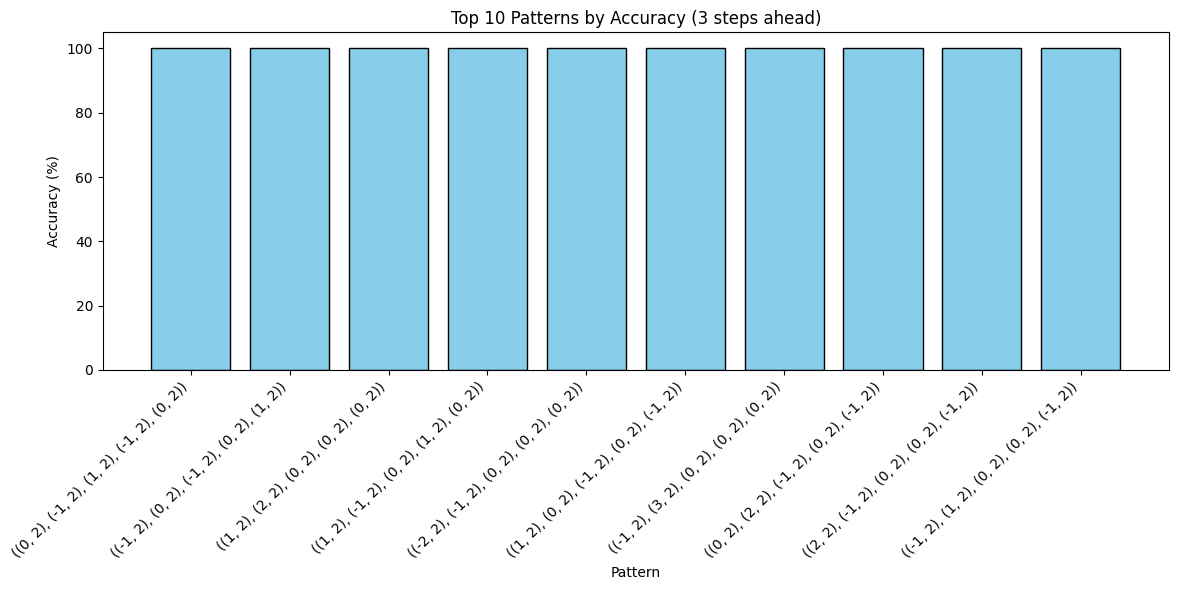

In [21]:
# 1. Analyze
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=3)


In [ ]:
results

,pattern,predicted,accuracy,direction_only_accuracy,predicted_direction,predicted_volume_cat,correct,total,timestamps
226,"((0, 2), (-1, 2), (1, 2), (-1, 2), (0, 2))","(0, 2)",100.00,100.00,0,2,5,5,"[3044, 3667, 3839, 6381, 6496]"
73,"((-1, 2), (0, 2), (-1, 2), (0, 2), (1, 2))","(0, 2)",100.00,100.00,0,2,6,6,"[184, 429, 1754, 1957, 5301, 5463]"
176,"((1, 2), (2, 2), (0, 2), (0, 2), (0, 2))","(0, 2)",100.00,100.00,0,2,7,7,"[990, 1163, 2708, 4556, 4616, 4660, 4918]"
157,"((1, 2), (-1, 2), (0, 2), (1, 2), (0, 2))","(0, 2)",100.00,100.00,0,2,5,5,"[767, 1150, 1198, 2997, 5557]"
30,"((-2, 2), (-1, 2), (0, 2), (0, 2), (0, 2))","(0, 2)",100.00,100.00,0,2,8,8,"[59, 501, 1222, 1455, 1658, 1893, 2117, 5652]"
153,"((1, 2), (0, 2), (-1, 2), (0, 2), (-1, 2))","(0, 2)",100.00,100.00,0,2,5,5,"[722, 1127, 2833, 4203, 6363]"
44,"((-1, 2), (3, 2), (0, 2), (0, 2), (0, 2))","(0, 2)",100.00,100.00,0,2,5,5,"[111, 2133, 2144, 5264, 5486]"
212,"((0, 2), (2, 2), (-1, 2), (0, 2), (-1, 2))","(0, 2)",100.00,100.00,0,2,5,5,"[2023, 2427, 4074, 5384, 6456]"
216,"((2, 2), (-1, 2), (0, 2), (0, 2), (-1, 2))","(0, 2)",100.00,100.00,0,2,5,5,"[2280, 3624, 4240, 5049, 6420]"
127,"((-1, 2), (1, 2), (0, 2), (0, 2), (-1, 2))","(0, 2)",100.00,100.00,0,2,7,7,"[547, 1109, 1842, 3074, 4563, 5255, 6338]"


In [ ]:

# 2. Pick top pattern
top_pattern = results.iloc[0]["pattern"]
timestamps = results.iloc[0]["timestamps"]


In [ ]:
timestamps

In [ ]:
%matplotlib inline

In [ ]:

# 3. Visualize matches
plot_pattern_matches(df, top_pattern, timestamps, seq_len=5, future_steps=3)


In [ ]:
results.head()

In [ ]:
format = '%Y-%m-%d %H:%M:%S'
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.set_index(pd.DatetimeIndex(df['Datetime']))

In [ ]:
import mplfinance as mpf

def plot_single_pattern_match(df, pattern_timestamps, seq_len=5, future_steps=2):
    if not pattern_timestamps:
        print("No timestamps provided.")
        return

    ts = pattern_timestamps[0]  # Try plotting just the first match
    df = df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex.")

    try:
        # Get full window for plotting
        idx = df.index.get_loc(ts)
        start_idx = idx - future_steps - seq_len + 1
        end_idx = idx + 1

        if start_idx < 0:
            print(f"Not enough data before timestamp: {ts}")
            return

        sub_df = df.iloc[start_idx:end_idx]

        # Ensure required columns
        sub_df = sub_df[['Open', 'High', 'Low', 'Close', 'Volume']]

        print(f"Showing pattern match ending at: {ts}")
        mpf.plot(sub_df, type='candle', volume=True, style='yahoo')

    except Exception as e:
        print(f"Error plotting pattern at {ts}: {e}")


In [ ]:
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=2)

# Select the top pattern and timestamps
top_pattern = results.iloc[0]['pattern']
pattern_timestamps = results.iloc[0]['timestamps']

# Plot one match
plot_single_pattern_match(df, pattern_timestamps, seq_len=5, future_steps=2)


In [ ]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_with_two_panels(df, pattern, timestamps, seq_len=5, future_steps=2, limit=3):
    df = df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex.")

    count = 0
    for ts in timestamps:
        try:
            idx = df.index.get_loc(ts)
            start_idx = idx - future_steps - seq_len + 1
            pattern_end_idx = idx - future_steps + 1
            full_end_idx = idx + 1

            if start_idx < 0 or full_end_idx >= len(df):
                continue

            pattern_df = df.iloc[start_idx:pattern_end_idx]
            real_future_candle = df.iloc[idx]
            ghost_date = df.index[idx]

            # Create figure with two subplots: one for real candles, one for predicted candles
            fig, (ax_real, ax_pred) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

            # Plot the real candles on the first panel using mplfinance
            mpf.plot(df.iloc[start_idx:full_end_idx], type='candle', ax=ax_real, style='charles', title=f"Real Candlestick Chart at {ghost_date.date()}")

            # Plot the predicted (ghost) candles on the second panel
            # We'll use blue dashed lines to represent the forecasted (ghost) candles.
            ax_pred.set_title(f"Predicted Candlestick Chart at {ghost_date.date()}")

            # Generate the predicted ghost candles: Simulating using predicted size (this can be customized)
            predicted_body = real_future_candle['Close'] - real_future_candle['Open']
            predicted_color = 'blue'

            # Create a "ghost" predicted candle based on the predicted movement
            ghost_open = real_future_candle['Open'] + predicted_body * 0.2  # Adjusted prediction
            ghost_close = ghost_open + (predicted_body * 0.2)  # Simulate the predicted candle

            ghost_high = max(ghost_open, ghost_close) + 0.005 * real_future_candle['Open']
            ghost_low = min(ghost_open, ghost_close) - 0.005 * real_future_candle['Open']

            # Plot the ghost predicted candle on the second panel
            ax_pred.plot([ghost_date, ghost_date], [ghost_low, ghost_high], color='blue', linestyle='--')
            ax_pred.add_patch(plt.Rectangle(
                (pd.to_datetime(ghost_date) - pd.Timedelta('0.2 days'), min(ghost_open, ghost_close)),
                0.4,
                abs(ghost_close - ghost_open),
                color='blue',
                alpha=0.3,
                label="Predicted Ghost Candle"
            ))

            # Final settings for the plot
            ax_pred.xaxis_date()
            ax_real.xaxis_date()

            # Labels and legend
            ax_real.legend()
            ax_pred.legend()

            # Display the grid and the plot
            plt.tight_layout()
            plt.show()

            count += 1
            if count >= limit:
                break

        except Exception as e:
            print(f"Error at {ts}: {e}")


In [ ]:
# After running analyze_pattern_accuracy_full()
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=2)

top_pattern = results.iloc[0]["pattern"]
timestamps = results.iloc[0]["timestamps"]

# Visualize top 3 matches with real and predicted candles on separate panels
plot_with_two_panels(df, top_pattern, timestamps, seq_len=5, future_steps=2, limit=3)


In [ ]:

from collections import defaultdict, Counter
import json
from nltk import ngrams

# Globals
live_data = pd.DataFrame(columns=["Date_Time", "Open", "High", "Low", "Close", "Volume"])
predicted_candles_buffer = []
pattern_stats = defaultdict(lambda: {"counts": Counter(), "total": 0})
SEQ_LEN = 5
MIN_OCCURRENCES = 5
CONFIDENCE_THRESHOLD = 0.6  # only use patterns with ≥60% accuracy


# === Prediction Engine (Offline Training) ===
def build_pattern_model(df, seq_len=5):
    global pattern_stats
    pattern_stats = defaultdict(lambda: {"counts": Counter(), "total": 0})

    df = df.copy()
    df['body_size'] = abs(df['Close'] - df['Open'])
    atr = df['body_size'].rolling(window=14).mean()
    df['size_category'] = ((df['Close'] - df['Open']) / atr).fillna(0)
    df['size_category'] = df['size_category'].apply(lambda x: 0 if abs(x) < 0.5 else int(np.sign(x) * min(abs(x), 3)))

    vol_mean = df['Volume'].mean()
    vol_std = df['Volume'].std()
    df['volume_category'] = ((df['Volume'] - vol_mean) / vol_std).apply(
        lambda x: 1 if x < -0.5 else (3 if x > 0.5 else 2))

    sequence = list(zip(df['size_category'], df['volume_category']))
    ngram_data = list(ngrams(sequence, seq_len + 1))

    for ngram_seq in ngram_data:
        pattern = ngram_seq[:-1]
        actual_next = ngram_seq[-1]
        pattern_stats[pattern]["counts"][actual_next] += 1
        pattern_stats[pattern]["total"] += 1


def predict_next_candles(current_df, n_preds=5):
    predictions = []
    df = current_df.copy()
    for _ in range(n_preds):
        if len(df) < SEQ_LEN:
            break

        # Categorize
        df['body_size'] = abs(df['Close'] - df['Open'])
        atr = df['body_size'].rolling(window=14).mean()
        df['size_category'] = ((df['Close'] - df['Open']) / atr).fillna(0)
        df['size_category'] = df['size_category'].apply(lambda x: 0 if abs(x) < 0.5 else int(np.sign(x) * min(abs(x), 3)))
        vol_mean = df['Volume'].mean()
        vol_std = df['Volume'].std()
        df['volume_category'] = ((df['Volume'] - vol_mean) / vol_std).apply(
            lambda x: 1 if x < -0.5 else (3 if x > 0.5 else 2))

        last_pattern = tuple(zip(df['size_category'].iloc[-SEQ_LEN:], df['volume_category'].iloc[-SEQ_LEN:]))

        if last_pattern not in pattern_stats:
            break

        counts = pattern_stats[last_pattern]["counts"]
        total = pattern_stats[last_pattern]["total"]
        best_next, count = counts.most_common(1)[0]
        confidence = count / total

        if confidence < CONFIDENCE_THRESHOLD:
            break

        # Build synthetic candle
        prev_close = df["Close"].iloc[-1]
        direction = np.sign(best_next[0])
        delta = 0.5 * df["body_size"].mean()
        open_price = prev_close
        close_price = prev_close + direction * delta
        high = max(open_price, close_price) + 0.2 * delta
        low = min(open_price, close_price) - 0.2 * delta
        volume = vol_mean + (best_next[1] - 2) * vol_std

        new_time = df["Date_Time"].iloc[-1] + pd.Timedelta(minutes=1)

        pred_candle = {
            "Date_Time": new_time,
            "Open": open_price,
            "Close": close_price,
            "High": high,
            "Low": low,
            "Volume": volume,
            "size_cat": best_next[0],
            "vol_cat": best_next[1],
            "Confidence": confidence
        }
        

        df = pd.concat([df, pd.DataFrame([pred_candle])], ignore_index=True)
        predictions.append(pred_candle)

    return predictions



In [ ]:
build_pattern_model(df,seq_len=5)

In [ ]:
df.head()

In [ ]:
ndf = predict_next_candles(df,n_preds=5)

In [ ]:
ndf

In [ ]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def plot_with_two_panels(df, pattern, timestamps, seq_len=5, future_steps=2, limit=3):
    df = df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex.")

    count = 0
    for ts in timestamps:
        try:
            idx = df.index.get_loc(ts)
            start_idx = idx - future_steps - seq_len + 1
            pattern_end_idx = idx - future_steps + 1
            full_end_idx = idx + 1

            if start_idx < 0 or full_end_idx >= len(df):
                continue

            pattern_df = df.iloc[start_idx:pattern_end_idx]
            real_future_candle = df.iloc[idx]
            ghost_date = df.index[idx]

            # Create figure with two subplots: one for real candles, one for predicted candles
            fig, (ax_real, ax_pred) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

            # Plot the real candles on the first panel using mplfinance
            mpf.plot(df.iloc[start_idx:full_end_idx], type='candle', ax=ax_real, style='charles', title=f"Real Candlestick Chart at {ghost_date.date()}")

            # Plot the predicted (ghost) candles on the second panel
            ax_pred.set_title(f"Predicted Candlestick Chart at {ghost_date.date()}")

            # Generate the predicted ghost candles: Simulating using predicted size (this can be customized)
            predicted_body = real_future_candle['Close'] - real_future_candle['Open']
            predicted_color = 'blue'

            # Create a "ghost" predicted candle based on the predicted movement
            ghost_open = real_future_candle['Open'] + predicted_body * 0.2  # Adjusted prediction
            ghost_close = ghost_open + (predicted_body * 0.2)  # Simulate the predicted candle

            ghost_high = max(ghost_open, ghost_close) + 0.005 * real_future_candle['Open']
            ghost_low = min(ghost_open, ghost_close) - 0.005 * real_future_candle['Open']

            # Plot the ghost predicted candle on the second panel
            ax_pred.plot([ghost_date, ghost_date], [ghost_low, ghost_high], color='blue', linestyle='--')
            ax_pred.add_patch(patches.Rectangle(
                (pd.to_datetime(ghost_date) - pd.Timedelta('0.2 days'), min(ghost_open, ghost_close)),
                0.4,
                abs(ghost_close - ghost_open),
                color='blue',
                alpha=0.3,
                label="Predicted Ghost Candle"
            ))

            # Final settings for the plot
            ax_pred.xaxis_date()
            ax_real.xaxis_date()

            # Labels and legend
            ax_real.legend()
            ax_pred.legend()

            # Display the grid and the plot
            plt.tight_layout()
            plt.show()

            count += 1
            if count >= limit:
                break

        except Exception as e:
            print(f"Error at {ts}: {e}")


In [ ]:
# After running analyze_pattern_accuracy_full()
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=2)

top_pattern = results.iloc[0]["pattern"]
timestamps = results.iloc[0]["timestamps"]

# Visualize top 3 matches with real and predicted candles on separate panels
plot_with_two_panels(df, top_pattern, timestamps, seq_len=5, future_steps=2, limit=3)


In [ ]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def plot_with_two_panels(df, pattern, timestamps, seq_len=5, future_steps=2, limit=3):
    df = df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex.")

    count = 0
    for ts in timestamps:
        try:
            idx = df.index.get_loc(ts)
            start_idx = idx - future_steps - seq_len + 1
            pattern_end_idx = idx - future_steps + 1
            full_end_idx = idx + 1

            if start_idx < 0 or full_end_idx >= len(df):
                continue

            pattern_df = df.iloc[start_idx:pattern_end_idx]
            real_future_candle = df.iloc[idx]
            ghost_date = df.index[idx]

            sub_df = pattern_df
            # Ensure required columns
            sub_df = sub_df[['Open', 'High', 'Low', 'Close', 'Volume']]

            print(f"Showing pattern match ending at: {ts}")
            mpf.plot(sub_df, type='candle', volume=True, style='yahoo')

            # Create figure with one panel for real candles
            fig, ax_real = plt.subplots(figsize=(12, 8))

            # Plot the real candles using mplfinance
            mpf.plot(df.iloc[start_idx:full_end_idx], type='candle', ax=ax_real, style='charles', title=f"Real Candlestick Chart at {ghost_date.date()}")

            # Create figure with second panel for predicted candles
            fig_pred, ax_pred = plt.subplots(figsize=(12, 8))

            # Plot the predicted (ghost) candles on the second panel
            ax_pred.set_title(f"Predicted Candlestick Chart at {ghost_date.date()}")

            # Generate the predicted ghost candles: Simulating using predicted size (this can be customized)
            predicted_body = real_future_candle['Close'] - real_future_candle['Open']
            predicted_color = 'blue'

            # Create a "ghost" predicted candle based on the predicted movement
            ghost_open = real_future_candle['Open'] + predicted_body * 0.2  # Adjusted prediction
            ghost_close = ghost_open + (predicted_body * 0.2)  # Simulate the predicted candle

            ghost_high = max(ghost_open, ghost_close) + 0.005 * real_future_candle['Open']
            ghost_low = min(ghost_open, ghost_close) - 0.005 * real_future_candle['Open']

            # Plot the ghost predicted candle on the second panel
            ax_pred.plot([ghost_date, ghost_date], [ghost_low, ghost_high], color='blue', linestyle='--')
            ax_pred.add_patch(patches.Rectangle(
                (pd.to_datetime(ghost_date) - pd.Timedelta('0.2 days'), min(ghost_open, ghost_close)),
                0.4,
                abs(ghost_close - ghost_open),
                color='blue',
                alpha=0.3,
                label="Predicted Ghost Candle"
            ))

            # Final settings for the plot
            ax_pred.xaxis_date()
            ax_real.xaxis_date()

            # Display the grid and the plot
            plt.tight_layout()

            # Display both figures: the real candles and the predicted candles
            plt.show()

            
            count += 1
            if count >= limit:
                break

        except Exception as e:
            print(f"Error at {ts}: {e}")


In [ ]:

def plot_single_pattern_match(df, pattern_timestamps, seq_len=5, future_steps=2):
    if not pattern_timestamps:
        print("No timestamps provided.")
        return

    ts = pattern_timestamps[0]  # Try plotting just the first match
    df = df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex.")

    try:
        # Get full window for plotting
        idx = df.index.get_loc(ts)
        start_idx = idx - future_steps - seq_len + 1
        end_idx = idx + 1

        if start_idx < 0:
            print(f"Not enough data before timestamp: {ts}")
            return

        sub_df = df.iloc[start_idx:end_idx]

        # Ensure required columns
        sub_df = sub_df[['Open', 'High', 'Low', 'Close', 'Volume']]

        print(f"Showing pattern match ending at: {ts}")
        mpf.plot(sub_df, type='candle', volume=True, style='yahoo')

    except Exception as e:
        print(f"Error plotting pattern at {ts}: {e}")

In [ ]:
# After running analyze_pattern_accuracy_full()
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=2)

top_pattern = results.iloc[0]["pattern"]
timestamps = results.iloc[0]["timestamps"]

# Visualize top 3 matches with real and predicted candles on separate panels
plot_with_two_panels(df, top_pattern, timestamps, seq_len=5, future_steps=2, limit=3)


In [ ]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def plot_real_and_predicted_charts(df, pattern, timestamps, seq_len=5, future_steps=2, limit=3):
    df = df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame index must be a DateTimeIndex.")

    count = 0
    for ts in timestamps:
        try:
            idx = df.index.get_loc(ts)
            start_idx = idx - future_steps - seq_len + 1
            pattern_end_idx = idx - future_steps + 1
            full_end_idx = idx + 1

            if start_idx < 0 or full_end_idx >= len(df):
                continue

            pattern_df = df.iloc[start_idx:pattern_end_idx]
            real_future_candle = df.iloc[idx]
            ghost_date = df.index[idx]

            # Create figure for real candlestick chart using mplfinance
            fig_real = mpf.figure(style='charles', figsize=(12, 6))
            ax_real = fig_real.add_subplot(1, 1, 1)

            # Plot the real candles using mplfinance
            mpf.plot(df.iloc[start_idx:full_end_idx], type='candle', ax=ax_real, title=f"Real Candlestick Chart at {ghost_date.date()}")

            # Create a separate figure for predicted candles
            fig_pred, ax_pred = plt.subplots(figsize=(12, 6))

            # Plot the predicted (ghost) candles on the second chart
            ax_pred.set_title(f"Predicted Candlestick Chart at {ghost_date.date()}")

            # Generate the predicted ghost candles: Simulating using predicted size (this can be customized)
            predicted_body = real_future_candle['Close'] - real_future_candle['Open']
            predicted_color = 'blue'

            # Create a "ghost" predicted candle based on the predicted movement
            ghost_open = real_future_candle['Open'] + predicted_body * 0.2  # Adjusted prediction
            ghost_close = ghost_open + (predicted_body * 0.2)  # Simulate the predicted candle

            ghost_high = max(ghost_open, ghost_close) + 0.005 * real_future_candle['Open']
            ghost_low = min(ghost_open, ghost_close) - 0.005 * real_future_candle['Open']

            # Plot the ghost predicted candle on the second panel
            ax_pred.plot([ghost_date, ghost_date], [ghost_low, ghost_high], color='blue', linestyle='--')
            ax_pred.add_patch(patches.Rectangle(
                (pd.to_datetime(ghost_date) - pd.Timedelta('0.2 days'), min(ghost_open, ghost_close)),
                0.4,
                abs(ghost_close - ghost_open),
                color='blue',
                alpha=0.3,
                label="Predicted Ghost Candle"
            ))

            # Display both figures: the real candles and the predicted candles
            plt.tight_layout()

            # Show the real candlestick chart
            fig_real.suptitle(f"Real Candlestick Chart - {ghost_date.date()}")
            plt.show()

            # Show the predicted (ghost) candlestick chart
            plt.tight_layout()
            ax_pred.legend()
            plt.show()

            count += 1
            if count >= limit:
                break

        except Exception as e:
            print(f"Error at {ts}: {e}")


In [ ]:
# After running analyze_pattern_accuracy_full()
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=2)

top_pattern = results.iloc[0]["pattern"]
timestamps = results.iloc[0]["timestamps"]

# Visualize top 3 matches with real and predicted candles on separate charts
plot_real_and_predicted_charts(df, top_pattern, timestamps, seq_len=5, future_steps=2, limit=3)


In [ ]:
import mplfinance as mpf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

def plot_real_and_predicted_charts(df, seq_len=5, future_steps=2, limit=3):
    # Ensure results are generated from your pattern analysis function
    results = analyze_pattern_accuracy_full(df, seq_len=seq_len, future_steps=future_steps)
    
    if results.empty:
        print("No patterns found.")
        return

    try:
        top_pattern = results.iloc[0]["pattern"]
        timestamps = results.iloc[0]["timestamps"]
        
        if not isinstance(timestamps, list):
            raise ValueError("Timestamps should be in a list format.")

    except Exception as e:
        print(f"Error accessing pattern data: {e}")
        return

    count = 0
    for ts in timestamps:
        try:
            idx = df.index.get_loc(ts)
            start_idx = idx - future_steps - seq_len + 1
            pattern_end_idx = idx - future_steps + 1
            full_end_idx = idx + 1

            if start_idx < 0 or full_end_idx >= len(df):
                continue

            # 1. Real Candlestick Chart using mplfinance
            fig_real, ax_real = plt.subplots(figsize=(12, 6))
            mpf.plot(df.iloc[start_idx:full_end_idx], type='candle', ax=ax_real, style='charles', title=f"Real Candlestick Chart at {df.index[idx].date()}")

            # 2. Predicted (Ghost) Candlestick Plot
            # fig_pred, ax_pred = plt.subplots(figsize=(12, 6))
            # ax_pred.set_title(f"Predicted Candlestick Chart at {df.index[idx].date()}")

            # # Get the real future candle (last candle in the pattern)
            # real_future_candle = df.iloc[idx]
            
            # # Calculate predicted ghost candles (mock prediction, you can adjust this part)
            # predicted_body = real_future_candle['Close'] - real_future_candle['Open']
            # ghost_open = real_future_candle['Open'] + predicted_body * 0.2
            # ghost_close = ghost_open + (predicted_body * 0.2)

            # ghost_high = max(ghost_open, ghost_close) + 0.005 * real_future_candle['Open']
            # ghost_low = min(ghost_open, ghost_close) - 0.005 * real_future_candle['Open']

            # # Plot the ghost (predicted) candle as a blue dashed line
            # ax_pred.plot([df.index[idx], df.index[idx]], [ghost_low, ghost_high], color='blue', linestyle='--')
            # ax_pred.add_patch(patches.Rectangle(
            #     (df.index[idx] - pd.Timedelta('0.2 days'), min(ghost_open, ghost_close)),
            #     0.4,  # width of the rectangle (simulated time span)
            #     abs(ghost_close - ghost_open),  # height of the rectangle (simulated body size)
            #     color='blue',
            #     alpha=0.3,
            #     label="Predicted Ghost Candle"
            # ))

            # Adjust layout and show plots
            plt.tight_layout()

            # Show Real Candlestick chart
            plt.show()

            # Show Predicted Ghost Candlestick chart
            ax_pred.legend()
            plt.show()

            count += 1
            if count >= limit:
                break

        except Exception as e:
            print(f"Error at {ts}: {e}")


In [ ]:
# Assuming `df` is your DataFrame and pattern analysis is already done
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=2)

# Extract top pattern and corresponding timestamps
top_pattern = results.iloc[0]["pattern"]
timestamps = results.iloc[0]["timestamps"]

# Visualize top 3 matches with real and predicted candles on separate charts
plot_real_and_predicted_charts(df, seq_len=5, future_steps=2, limit=3)


In [ ]:
import mplfinance as mpf
import pandas as pd
import yfinance as yf


In [ ]:
%matplotlib inline


In [ ]:

# Sample data
df = yf.download("AAPL", start="2023-01-01", end="2023-03-01")
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]


In [ ]:
df.head()

In [ ]:
df['High']=df['High'].astype(int)
df.index = pd.to_datetime(df.index)
mpf.plot(df, type='candlestick', volume=True, style='charles', title="AAPL Candlestick Example")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import matplotlib.dates as mdates

def plot_real_and_predicted_charts(df, seq_len=5, future_steps=2, limit=3):
    # Ensure results are generated from your pattern analysis function
    results = analyze_pattern_accuracy_full(df, seq_len=seq_len, future_steps=future_steps)
    
    if results.empty:
        print("No patterns found.")
        return

    try:
        top_pattern = results.iloc[0]["pattern"]
        timestamps = results.iloc[0]["timestamps"]
        
        if not isinstance(timestamps, list):
            raise ValueError("Timestamps should be in a list format.")

    except Exception as e:
        print(f"Error accessing pattern data: {e}")
        return

    count = 0
    for ts in timestamps:
        try:
            idx = df.index.get_loc(ts)
            start_idx = idx - future_steps - seq_len + 1
            pattern_end_idx = idx - future_steps + 1
            full_end_idx = idx + 1

            if start_idx < 0 or full_end_idx >= len(df):
                continue

            # Create a figure for both real and predicted candles
            fig, ax = plt.subplots(figsize=(12, 6))

            # Real Candlestick Chart using Matplotlib
            # Plot the real candles
            for i in range(start_idx, full_end_idx):
                candle = df.iloc[i]
                color = 'green' if candle['Close'] > candle['Open'] else 'red'
                ax.plot([candle.name, candle.name], [candle['Low'], candle['High']], color=color, lw=1.5)  # Candle wick
                ax.add_patch(patches.Rectangle((candle.name - pd.Timedelta('0.2 days'), min(candle['Open'], candle['Close'])),
                                               0.4,  # width of the rectangle (simulated time span)
                                               abs(candle['Close'] - candle['Open']),  # height of the rectangle (simulated body size)
                                               color=color, alpha=0.8))

            # Get the real future candle (last candle in the pattern)
            real_future_candle = df.iloc[idx]

            # Calculate predicted ghost candles (mock prediction, you can adjust this part)
            predicted_body = real_future_candle['Close'] - real_future_candle['Open']
            ghost_open = real_future_candle['Open'] + predicted_body * 0.2
            ghost_close = ghost_open + (predicted_body * 0.2)

            ghost_high = max(ghost_open, ghost_close) + 0.005 * real_future_candle['Open']
            ghost_low = min(ghost_open, ghost_close) - 0.005 * real_future_candle['Open']

            # Plot the ghost (predicted) candle as a blue dashed line
            ax.plot([df.index[idx], df.index[idx]], [ghost_low, ghost_high], color='blue', linestyle='--', lw=2)
            ax.add_patch(patches.Rectangle(
                (df.index[idx] - pd.Timedelta('0.2 days'), min(ghost_open, ghost_close)),
                0.4,  # width of the rectangle (simulated time span)
                abs(ghost_close - ghost_open),  # height of the rectangle (simulated body size)
                color='blue',
                alpha=0.3,
                label="Predicted Ghost Candle"
            ))

            # Set titles and labels
            ax.set_title(f"Real and Predicted Candlestick Chart at {df.index[idx].date()}", fontsize=16)
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Price', fontsize=12)

            # Format x-axis as dates
            ax.xaxis.set_major_locator(mdates.WeekdayLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.xticks(rotation=45)
            
            # Show the chart with both real and predicted candles
            ax.legend()
            plt.tight_layout()
            plt.show()

            count += 1
            if count >= limit:
                break

        except Exception as e:
            print(f"Error at {ts}: {e}")


In [ ]:
# Assuming `df` is your DataFrame and pattern analysis is already done
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=2)

# Extract top pattern and corresponding timestamps
top_pattern = results.iloc[0]["pattern"]
timestamps = results.iloc[0]["timestamps"]

# Visualize top 3 matches with real and predicted candles on the same chart
plot_real_and_predicted_charts(df, seq_len=5, future_steps=2, limit=3)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import matplotlib.dates as mdates

def plot_real_and_predicted_charts(df, seq_len=5, future_steps=2, limit=3):
    # Ensure results are generated from your pattern analysis function
    results = analyze_pattern_accuracy_full(df, seq_len=seq_len, future_steps=future_steps)
    
    if results.empty:
        print("No patterns found.")
        return

    try:
        top_pattern = results.iloc[0]["pattern"]
        timestamps = results.iloc[0]["timestamps"]
        
        if not isinstance(timestamps, list):
            raise ValueError("Timestamps should be in a list format.")

    except Exception as e:
        print(f"Error accessing pattern data: {e}")
        return

    count = 0
    for ts in timestamps:
        try:
            idx = df.index.get_loc(ts)
            start_idx = idx - future_steps - seq_len + 1
            pattern_end_idx = idx - future_steps + 1
            full_end_idx = idx + 1

            if start_idx < 0 or full_end_idx >= len(df):
                continue

            # Real Candlestick Chart using Matplotlib
            fig_real, ax_real = plt.subplots(figsize=(12, 6))
            # Plot the real candles
            for i in range(start_idx, full_end_idx):
                candle = df.iloc[i]
                color = 'green' if candle['Close'] > candle['Open'] else 'red'
                ax_real.plot([candle.name, candle.name], [candle['Low'], candle['High']], color=color, lw=1.5)  # Candle wick
                ax_real.add_patch(patches.Rectangle((candle.name - pd.Timedelta('0.2 days'), min(candle['Open'], candle['Close'])),
                                                    0.4,  # width of the rectangle (simulated time span)
                                                    abs(candle['Close'] - candle['Open']),  # height of the rectangle (simulated body size)
                                                    color=color, alpha=0.8))

            # Set titles and labels for Real Chart
            ax_real.set_title(f"Real Candlestick Chart at {df.index[idx].date()}", fontsize=16)
            ax_real.set_xlabel('Date', fontsize=12)
            ax_real.set_ylabel('Price', fontsize=12)

            # Format x-axis as dates
            ax_real.xaxis.set_major_locator(mdates.WeekdayLocator())
            ax_real.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.xticks(rotation=45)
            
            # Show the real candlestick chart
            plt.tight_layout()
            plt.show()

            # Predicted (Ghost) Candlestick Chart using Matplotlib
            fig_pred, ax_pred = plt.subplots(figsize=(12, 6))

            # Get the real future candle (last candle in the pattern)
            real_future_candle = df.iloc[idx]
            
            # Calculate predicted ghost candles (mock prediction, you can adjust this part)
            predicted_body = real_future_candle['Close'] - real_future_candle['Open']
            ghost_open = real_future_candle['Open'] + predicted_body * 0.2
            ghost_close = ghost_open + (predicted_body * 0.2)

            ghost_high = max(ghost_open, ghost_close) + 0.005 * real_future_candle['Open']
            ghost_low = min(ghost_open, ghost_close) - 0.005 * real_future_candle['Open']

            # Plot the ghost (predicted) candle as a blue dashed line
            ax_pred.plot([df.index[idx], df.index[idx]], [ghost_low, ghost_high], color='blue', linestyle='--', lw=2)
            ax_pred.add_patch(patches.Rectangle(
                (df.index[idx] - pd.Timedelta('0.2 days'), min(ghost_open, ghost_close)),
                0.4,  # width of the rectangle (simulated time span)
                abs(ghost_close - ghost_open),  # height of the rectangle (simulated body size)
                color='blue',
                alpha=0.3,
                label="Predicted Ghost Candle"
            ))

            # Set titles and labels for Predicted Chart
            ax_pred.set_title(f"Predicted Candlestick Chart at {df.index[idx].date()}", fontsize=16)
            ax_pred.set_xlabel('Date', fontsize=12)
            ax_pred.set_ylabel('Price', fontsize=12)

            # Format x-axis as dates
            ax_pred.xaxis.set_major_locator(mdates.WeekdayLocator())
            ax_pred.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.xticks(rotation=45)
            
            # Show the predicted candlestick chart
            ax_pred.legend()
            plt.tight_layout()
            plt.show()

            count += 1
            if count >= limit:
                break

        except Exception as e:
            print(f"Error at {ts}: {e}")


In [ ]:
# Assuming `df` is your DataFrame and pattern analysis is already done
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=2)

# Extract top pattern and corresponding timestamps
top_pattern = results.iloc[0]["pattern"]
timestamps = results.iloc[0]["timestamps"]

# Visualize top 3 matches with real and predicted candles in separate charts
plot_real_and_predicted_charts(df, seq_len=5, future_steps=2, limit=3)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import numpy as np

def plot_real_and_predicted_charts(df, seq_len=5, future_steps=2):
    # Ensure results are generated from your pattern analysis function
    results = analyze_pattern_accuracy_full(df, seq_len=seq_len, future_steps=future_steps)
    
    if results.empty:
        print("No patterns found.")
        return

    # Extract the top pattern and timestamps
    try:
        top_pattern = results.iloc[0]["pattern"]
        timestamps = results.iloc[0]["timestamps"]
    except Exception as e:
        print(f"Error accessing pattern data: {e}")
        return

    # Step 1: Plot the real candlestick chart with colored patterns
    fig_real, ax_real = plt.subplots(figsize=(12, 6))

    for i in range(len(df)):
        candle = df.iloc[i]
        color = 'green' if candle['Close'] > candle['Open'] else 'red'  # Default color for the candle
        ax_real.plot([candle.name, candle.name], [candle['Low'], candle['High']], color=color, lw=1.5)  # Wick (line)
        
        # ax_real.add_patch(patches.Rectangle((candle.name - pd.Timedelta('0.2 days').to_numeric('ns'), min(candle['Open'], candle['Close'])),
        #                                     0.4,  # width of the rectangle (time span)
        #                                     abs(candle['Close'] - candle['Open']),  # height of the rectangle (body size)
        #                                     color=color, alpha=0.8))  # Body (rectangle)
        
    # Set titles and labels for Real Chart
    ax_real.set_title(f"Real Candlestick Chart", fontsize=16)
    ax_real.set_xlabel('Date', fontsize=12)
    ax_real.set_ylabel('Price', fontsize=12)

    # Format x-axis as dates
    ax_real.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax_real.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    # Show the real candlestick chart
    plt.tight_layout()
    plt.show()

    # Step 2: Plot predicted candles on a separate chart
    fig_pred, ax_pred = plt.subplots(figsize=(12, 6))

    for ts in timestamps:
        try:
            idx = df.index.get_loc(ts)

            # Get the real future candle (last candle in the pattern)
            real_future_candle = df.iloc[idx]

            # Calculate predicted ghost candles (mock prediction logic)
            predicted_body = real_future_candle['Close'] - real_future_candle['Open']
            ghost_open = real_future_candle['Open'] + predicted_body * 0.2
            ghost_close = ghost_open + (predicted_body * 0.2)

            ghost_high = max(ghost_open, ghost_close) + 0.005 * real_future_candle['Open']
            ghost_low = min(ghost_open, ghost_close) - 0.005 * real_future_candle['Open']

            # Plot the ghost (predicted) candle as a blue dashed line
            ax_pred.plot([df.index[idx], df.index[idx]], [ghost_low, ghost_high], color='blue', linestyle='--', lw=2)
            # ax_pred.add_patch(patches.Rectangle(
            #     (df.index[idx] - pd.Timedelta('0.2 days').to_numeric('ns'), min(ghost_open, ghost_close)),
            #     0.4,  # width of the rectangle (simulated time span)
            #     abs(ghost_close - ghost_open),  # height of the rectangle (simulated body size)
            #     color='blue',
            #     alpha=0.3,
            #     label="Predicted Ghost Candle"
            # ))

            # Set titles and labels for Predicted Chart
            ax_pred.set_title(f"Predicted Candlestick Chart at {df.index[idx].date()}", fontsize=16)
            ax_pred.set_xlabel('Date', fontsize=12)
            ax_pred.set_ylabel('Price', fontsize=12)

            # Format x-axis as dates
            ax_pred.xaxis.set_major_locator(mdates.WeekdayLocator())
            ax_pred.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.xticks(rotation=45)

            # Show the predicted candlestick chart
            ax_pred.legend()
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error at {ts}: {e}")


In [ ]:
# Assuming `df` is your DataFrame and pattern analysis is already done
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=2)

# Extract top pattern and corresponding timestamps
top_pattern = results.iloc[0]["pattern"]
timestamps = results.iloc[0]["timestamps"]

# Visualize the real and predicted candles
plot_real_and_predicted_charts(df, seq_len=5, future_steps=2)


In [ ]:
def plot_predicted_candles(df, results, top_n=1, seq_len=5, future_steps=3):
    if results.empty:
        print("No matching patterns to visualize.")
        return

    for i in range(min(top_n, len(results))):
        row = results.iloc[i]
        pattern = row['pattern']
        timestamps = row['timestamps']
        predicted = row['predicted']
        
        print(f"\nPattern {i+1}: {pattern} → Predicted {predicted}, Accuracy: {row['accuracy']}%")
        
        # Extract and plot real + predicted candles at the matched timestamps
        for t in timestamps[:3]:  # Limit to 3 examples per pattern
            try:
                future_idx = df.index.get_loc(t)
                start_idx = max(future_idx - seq_len - 2, 0)
                end_idx = future_idx + 1

                data_slice = df.iloc[start_idx:end_idx].copy()

                # Highlight the predicted candle
                data_slice["highlight"] = ""
                if t in data_slice.index:
                    data_slice.loc[t, "highlight"] = "predicted"

                # Build additional styling
                mc = mpf.make_marketcolors(
                    up='green', down='red',
                    edge='black', wick='black',
                    volume='in',
                    ohlc='i'
                )
                s = mpf.make_mpf_style(marketcolors=mc)

                # Add predicted ghost candle as a custom overlay
                ghost_candle = df.loc[t]
                ghost_open = ghost_candle['Open']
                ghost_close = ghost_candle['Close']
                ghost_high = ghost_candle['High']
                ghost_low = ghost_candle['Low']
                ghost_volume = ghost_candle['Volume']

                # Create a ghost DataFrame
                ghost_df = pd.DataFrame({
                    'Open': [ghost_open],
                    'High': [ghost_high],
                    'Low': [ghost_low],
                    'Close': [ghost_close],
                    'Volume': [ghost_volume]
                    
                }, index=[t])

                print(f"📌 Plotting match at {t.date()} with predicted ghost candle.")
                print(ghost_df)
                # Plot
                mpf.plot(
                    data_slice,
                    type='candle',
                    style=s,
                    title=f"Pattern Match - Real vs Predicted Candle at {t.date()}",
                    ylabel='Price',
                    volume=True,
                    addplot=[
                        mpf.make_addplot(ghost_df, type='candle', color='blue', width=0.5,panel=2)
                    ]
                    
                ) 

            except Exception as e:
                print(f"❌ Error at {t}: {e}")


In [ ]:
results = analyze_pattern_accuracy_full(df, seq_len=5, future_steps=3)
plot_predicted_candles(df, results, top_n=1, seq_len=5, future_steps=3)


In [325]:
global pattern_stats
def predict_next_candles(current_df, n_preds=5):
    predictions = []
    df = current_df.copy()
    
    for _ in range(n_preds):
        if len(df) < SEQ_LEN:
            break

        df['body_size'] = abs(df['Close'] - df['Open'])
        atr = df['body_size'].rolling(window=14).mean()
        df['size_category'] = ((df['Close'] - df['Open']) / atr).fillna(0)
        df['size_category'] = df['size_category'].apply(lambda x: 0 if abs(x) < 0.5 else int(np.sign(x) * min(abs(x), 3)))
        vol_mean = df['Volume'].mean()
        vol_std = df['Volume'].std()
        df['volume_category'] = ((df['Volume'] - vol_mean) / vol_std).apply(
            lambda x: 1 if x < -0.5 else (3 if x > 0.5 else 2))

        last_pattern = tuple(zip(df['size_category'].iloc[-SEQ_LEN:], df['volume_category'].iloc[-SEQ_LEN:]))

        if last_pattern not in pattern_stats:
            break

        counts = pattern_stats[last_pattern]["counts"]
        total = pattern_stats[last_pattern]["total"]
        best_next, count = counts.most_common(1)[0]
        confidence = count / total

        if confidence < CONFIDENCE_THRESHOLD:
            break

        prev_close = df["Close"].iloc[-1]
        direction = np.sign(best_next[0])
        delta = 0.5 * df["body_size"].mean()
        open_price = prev_close
        close_price = prev_close + direction * delta
        high = max(open_price, close_price) + 0.2 * delta
        low = min(open_price, close_price) - 0.2 * delta
        volume = vol_mean + (best_next[1] - 2) * vol_std
        new_time = df["Date_Time"].iloc[-1] + pd.Timedelta(minutes=1)

        pred_candle = {
            "Date_Time": new_time,
            "Open": open_price,
            "Close": close_price,
            "High": high,
            "Low": low,
            "Volume": volume,
            "is_predicted": True,
            "Confidence": confidence
        }

        df = pd.concat([df, pd.DataFrame([pred_candle])], ignore_index=True)
        predictions.append(pred_candle)

    return df, predictions


In [ ]:
import mplfinance as mpf
import pandas as pd

def plot_with_predictions(df_with_preds):
    df = df_with_preds.copy()
    df["Date_Time"] = pd.to_datetime(df["Date_Time"])
    df.set_index("Date_Time", inplace=True)

    df_real = df[df.get("is_predicted") != True]
    df_pred = df[df.get("is_predicted") == True]

    # Prepare overlay plots for predicted candles
    add_plots = []
    for idx, row in df_pred.iterrows():
        # Create ghost candle bars
        color = 'blue' if row['Close'] >= row['Open'] else 'deepskyblue'
        add_plots.append(mpf.make_addplot(
            [row['Close']],  # just show close price level as bar
            type='bar',
            width=0.4,
            color=color,
            panel=0,
            secondary_y=False,
            ax=None
        ))

    # Market colors and style
    mc = mpf.make_marketcolors(up='green', down='red', inherit=True)
    s = mpf.make_mpf_style(marketcolors=mc)

    mpf.plot(
        df,
        type='candle',
        style=s,
        title="Real + Predicted Ghost Candles",
        ylabel="Price",
        volume=True,
        addplot=add_plots,
        tight_layout=True
    )


In [330]:
# Step 1: Build model
build_pattern_model(df, seq_len=5)


In [327]:
df_with_preds = df.copy()
# Step 2: Generate predictions
df_with_preds, preds = predict_next_candles(df_with_preds, n_preds=1)


In [20]:
pattern_stats

NameError: name 'pattern_stats' is not defined

In [331]:
pattern_stats

defaultdict(<function __main__.build_pattern_model.<locals>.<lambda>()>,
            {((0, 3),
              (0, 2),
              (0, 2),
              (0, 2),
              (0,
               2)): {'counts': Counter({(0, 2): 2,
                       (2, 2): 1,
                       (-1, 2): 1}), 'total': 4},
             ((0, 2),
              (0, 2),
              (0, 2),
              (0, 2),
              (0,
               2)): {'counts': Counter({(0, 2): 313,
                       (-1, 2): 68,
                       (1, 2): 61,
                       (2, 2): 22,
                       (-2, 2): 20,
                       (-3, 2): 14,
                       (3, 2): 12,
                       (2, 3): 2}), 'total': 512},
             ((0, 2),
              (0, 2),
              (0, 2),
              (0, 2),
              (1,
               2)): {'counts': Counter({(0, 2): 49,
                       (-1, 2): 24,
                       (1, 2): 13,
                       (2, 2): 5,


In [328]:
df_with_preds.columns

Index(['Date', 'Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Date_Time',
       'body_size', 'size_category', 'volume_category', 'Datetime'],
      dtype='object')

In [323]:
preds

[]

In [307]:

# Step 3: Plot real + predicted candles
plot_with_predictions(df_with_preds)


KeyError: True

In [4]:

df2 = data[['Date','time','Open',   'High',    'Low',  'Close',  'Volume' ]].copy()


df = df2.rename(columns={'Date':'date', 'Open':'open',   'High':'high',    'Low':'low',  'Close':'close',  'Volume':'volume'})


NameError: name 'data' is not defined

In [19]:

import pandas as pd

# Define size and volume categories
size_categories = [0, 1, 2, 3, 4, 5]
volume_categories = [1, 2, 3]

# Example candlestick and volume data (replace with your actual data)
# data = {'open': [10, 12, 11, 13, 14, 15, 10],
#         'high': [12, 14, 13, 15, 16, 17, 12],
#         'low': [9, 11, 10, 12, 13, 14, 9],
#         'close': [11, 13, 12, 14, 15, 16, 11],
#         'volume': [100, 200, 150, 250, 180, 300, 120]
#         }

# df = pd.DataFrame(data)

# Function to classify candlestick size
def classify_size(candle_data):
  body_size = abs(candle_data['close'] - candle_data['open'])
  if body_size <= (df['close'].max() - df['close'].min()) * 0.05:
    return 0  # Tiny
  elif body_size <= (df['close'].max() - df['close'].min()) * 0.1:
    return 1  # Small
  elif body_size <= (df['close'].max() - df['close'].min()) * 0.2:
    return 2  # Medium
  elif body_size <= (df['close'].max() - df['close'].min()) * 0.3:
    return 3  # Large
  elif body_size <= (df['close'].max() - df['close'].min()) * 0.4:
    return 4  # Very Large
  else:
    return 5  # Massive

# Function to classify volume
def classify_volume(volume):
  if volume <= df['volume'].mean() * 0.5:
    return 1  # Low
  elif volume <= df['volume'].mean() * 1.5:
    return 2  # Medium
  else:
    return 3  # High

# Apply classification
df['size'] = df.apply(classify_size, axis=1)
df['volume_class'] = df['volume'].apply(classify_volume)

print(df.head())
# Sequence matching (example: look for a small green candle followed by a larger red candle)
def check_sequence(df):
  sequence_found = False
  for i in range(len(df) - 1):
    if (df['size'][i] == 1 and df['close'][i] > df['open'][i] and # Green candle
        df['size'][i+1] > df['size'][i] and # Larger candle
        df['close'][i+1] < df['open'][i+1] and # Red candle
        df['volume_class'][i] <= df['volume_class'][i+1]):  # Volume increase
      sequence_found = True
      print(f"Sequence found at index {i}: Small green candle followed by larger red candle with increasing volume")
      print(df.iloc[i:i+2].to_string())
      break
  if not sequence_found:
    print("Sequence not found.")

# Run the checks
check_sequence(df)


KeyError: 'close'

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# # Generate random time-series data
# np.random.seed(42)
# dates = pd.date_range(start='2022-01-01', periods=100, freq='D')
# values = np.random.randn(100).cumsum()

# # Create a DataFrame from the generated data
# data = pd.DataFrame({'date': dates, 'value': values})

# Set the 'date' column as the index
#df2.set_index('date', inplace=True)

# Plot the time-series data
plt.plot(df.index, df['size'])
plt.xlabel('time')
plt.ylabel('size')
plt.xticks(rotation = 45)
plt.title('Time Series Data')
plt.show()

NameError: name 'df' is not defined